# Capstone Project - The Battle of the Neighborhoods

## Introduction

How do nearby venues impact the house prices in London?

If an individual was looking to make a house purchase in London UK, they may wish to consider how local venues impact the house price. While some may be obvious, for example, living near a night club would have an adverse impact, others maybe less clean-cut.

This analysis aims to quantify and rank the impact of various venue types within a set proximity of a property. This should allow the purchaser to make a more informed decision. For example, is a property over or undervalued? What impact will local developments have on the future house price.

## Data

#### Data Sources

1 London house price data is published by the HM Land Registry on http://publicdata.landregistry.gov.uk/ each month. It provides average house prices for all counties in the UK. 

2 Local venue information for each London Borough is captured using the Foursquare API. 

##### 1. HM Land Registry

The house price data will contains over 20 years of historical data that is not required for this analysis. I will exclude that along with non-London counties. Latitude and Longitude data will need to be added using the Geopy library.


In [3]:
!pip install pandas

In [63]:
import pandas as pd
import numpy as np
import requests # library to handle requests
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!pip install sklearn
from sklearn import linear_model 

import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

Solving environment: ...working... done

# All requested packages already installed.



In [5]:
#Gather UK average house price data 
df = pd.read_csv("http://publicdata.landregistry.gov.uk/market-trend-data/house-price-index-data/Average-prices-2019-01.csv")
#df = pd.read_csv("http://publicdata.landregistry.gov.uk/market-trend-data/house-price-index-data/UK-HPI-full-file-2019-01.csv")
print(df.shape)

#Remove historical data
df= df[df['Date']==df['Date'].max()]

#remove unneeded columns
df.drop(columns=['Date','Monthly_Change','Annual_Change','Average_Price_SA'], inplace=True)
df.dropna(inplace=True)
print(df.shape)

#Exclude not London boroughs
#Area code - Code of geography (Country, Regional, County/Unitary/District Authority and London Borough)
included_areas = ['E09']
for area in included_areas:
    df = df[df['Area_Code'].str.slice(stop=3)==area]

#df = df[(df['Region_Name']=="City of Westminster")]
print(df.shape)

(125874, 7)
(441, 3)
(33, 3)


In [6]:
#Add lontitude and lattitude data
addresses = df['Region_Name']
latitude = []
longitude = []

for address in addresses:
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address+", London, UK")
    try:
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    except:
        latitude.append(0)
        longitude.append(0)
        
df['Latitude']= latitude
df['Longitude']= longitude

In [7]:
#remove regions that location information was not available
df = df[(df['Latitude']!=0)| (df['Longitude']!=0)]
print(df.shape[0])
df.head()

33


,Region_Name,Area_Code,Average_Price,Latitude,Longitude
125514,City of Westminster,E09000033,959466.0747,51.497321,-0.137149
125524,City of London,E09000001,868257.9880,51.515618,-0.091998
125525,Barking and Dagenham,E09000002,299399.3694,51.554117,0.150504
125526,Barnet,E09000003,516915.9846,51.648784,-0.172913
125527,Bexley,E09000004,341059.9194,51.441679,0.150488


##### 2. HM Land Registry

Venue data from Foursquare is received in JSON format which will need to be flattened.

In [22]:
CLIENT_ID = 'QKP4KVQQZPVXMOKNIXHGQAT1E2IJZCHQPFB4XJGP3MC0CFUO' # your Foursquare ID
CLIENT_SECRET = '1N5BIRBR1EA5CO1QFMNHU1241SOFM5KJLLQRJGMDC0NOYWPH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 300 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius
categoryId = ''

In [23]:
#What are the most popular places nearby?

def getNearbyVenues(names, latitudes, longitudes, avg_price, radius=1000):
    
    
    region_list = []
    price_list = []
    
    for name, lat, lng, price in zip(names, latitudes, longitudes, avg_price):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(    
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)
        
        #print(url) 
        
        # make the GET request
        results = requests.get(url).json()["response"]
        
        #flatten JSON file
        resultsVen = json_normalize(results['venues'])
        resultsCat = json_normalize(data=results['venues'], record_path=['categories'], record_prefix='cat_', errors='ignore')
        resultsVenCat = pd.concat([resultsVen, resultsCat], axis=1)
        resultsVenCat = resultsVenCat[['name','location.distance','location.formattedAddress','location.lat','location.lng','cat_name']]
        
        #Add region name and average price 
        for i in range(0,resultsVen.shape[0]):
            region_list.append(name)
            price_list.append(price)
        
        region_list = pd.DataFrame(region_list, columns=['Region Name'])
        price_list = pd.DataFrame(price_list, columns=['Region Avg Price'])
        
        nearbyVenues = pd.concat([region_list, price_list, resultsVenCat], axis=1)

    return(nearbyVenues)

In [54]:
london_venues = pd.DataFrame()

#request venue information for each region and store in regions_venues
for region in df['Region_Name'].unique():
    region_venues = df[df['Region_Name']==region]
    london_venues = london_venues.append((getNearbyVenues(names=region_venues['Region_Name'],
                                                  latitudes=region_venues['Latitude'],
                                                  longitudes=region_venues['Longitude'],
                                                  avg_price=region_venues['Average_Price'])),ignore_index=True)
    
#rename columns
london_venues.rename(columns={'name':'Venue Name',
                          'location.distance':'Venue Distance',
                          'location.formattedAddress':'Venue Address',
                          'location.lat':'Venue Lat',
                          'location.lng':'Venue Lng',
                          'cat_name':'Venue Category'}, inplace=True)

print(london_venues.shape)
london_venues.head()

(5026, 8)


,Region Name,Region Avg Price,Venue Name,Venue Distance,Venue Address,Venue Lat,Venue Lng,Venue Category
0,City of Westminster,959466.0747,All Bar One,13,"[58 Victoria St, Victoria, Greater London, SW1...",51.497418,-0.137043,Bar
1,City of Westminster,959466.0747,Little Waitrose & Partners,13,"[62 Victoria St, Greater London, SW1E 6QP, Uni...",51.497443,-0.137177,Grocery Store
2,City of Westminster,959466.0747,Labour Party HQ,61,"[105 Victoria St (Southside), London, Greater ...",51.496948,-0.137801,Non-Profit
3,City of Westminster,959466.0747,Simba Sleep,49,"[Southside (105 Victoria St), London, Greater ...",51.496906,-0.136903,Mattress Store
4,City of Westminster,959466.0747,Edelman UK,2,"[105 Victoria St. (Buckingham Gate), London, G...",51.497304,-0.137162,Office


In [59]:
#Drop rows where venue category is unavailable
london_venues.dropna(subset=['Venue Category'],inplace=True)
london_venues.shape

(4799, 8)

#### 2.3 Feature Selection

The venue categorisations captured through the Foursquare API will be used as a feature set. To prepare this I will need to aggregate the data by London Borough using the feature set as column headers.

In [25]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Average Price'] = london_venues['Region Avg Price'] 
london_onehot['Region Name'] = london_venues['Region Name'] 

#Reorder headings
fixed_columns = [london_onehot.columns[-1]] + [london_onehot.columns[-2]] + list(london_onehot.columns[:-2])
london_onehot = london_onehot[fixed_columns]

#Group by London Borough
df1 = london_onehot.groupby(['Region Name','Average Price']).sum()
df1.reset_index(inplace=True)
df1.head()

,Region Name,Average Price,Accessories Store,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,...,Warehouse,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Barking and Dagenham,299399.3694,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
1,Barnet,516915.9846,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bexley,341059.9194,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,Brent,476933.0759,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bromley,443289.1746,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,4,0,0


In [60]:
#Create dataframe of feature list
df_features = pd.DataFrame(df1.columns)
df_features = df_features.iloc[2:df1.shape[1], :]
df_features.reset_index(inplace=True)

Now we have the dataset in the required format we can run our analysis.

## Methodology & Analysis

We need to determine which feature/venue has the biggest impact on the house price but first let's see whether just simply increased number of venues results increased property value

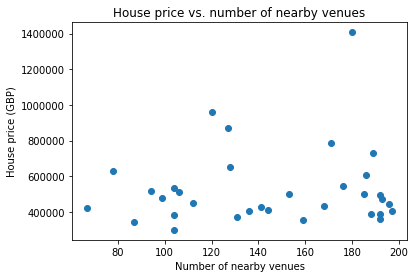

In [82]:
venue_count = london_venues.groupby(['Region Name','Region Avg Price']).count()
venue_count.reset_index(inplace=True)
venue_count = venue_count[['Region Name','Region Avg Price','Venue Category']]
venue_count.sort_values(by=['Venue Category'],inplace=True)


plt.scatter(venue_count['Venue Category'],venue_count['Region Avg Price'])
plt.title('House price vs. number of nearby venues')
plt.xlabel('Number of nearby venues')
plt.ylabel('House price (GBP)')
plt.show()

In [80]:
venue_count.corr()

,Region Avg Price,Venue Category
Region Avg Price,1.00000,0.09475
Venue Category,0.09475,1.00000


The scatter plot and 'corr' function shows there is no correlation between house price and the number of nearby venues. This shows that an area with lots of venues will have minimal impact on house price in London.

In [ ]:
regr = linear_model.LinearRegression()

#Set venues as features
x = df1.iloc[:, 2:df1.shape[1]]

#Set price as result(y)
y=df1[['Average Price']]

#Fit data
regr.fit(x, y)

In [16]:
regr = linear_model.LinearRegression()

#Set venues as features
x = df1.iloc[:, 2:df1.shape[1]]

#Set price as result(y)
y=df1[['Average Price']]

#Fit data
regr.fit(x, y)

#Add feature labels and sort
coefs = pd.DataFrame(regr.coef_).T
df_coef = pd.concat([df_features, coefs],axis=1,ignore_index=True)
df_coef.drop(columns=0, inplace=True)
df_coef.rename(columns={1:'Venue Category',2:'Coefficient'}, inplace=True)
df_coef.sort_values(by=['Coefficient'],inplace=True)

#print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[-3.85392914e+03 -5.72399489e+03 -7.60439865e+02 -7.54245598e+02
  -1.88536209e+03  1.37655273e+03  1.26451237e+03  8.41594150e+03
  -6.50981265e+03 -2.88100039e+02 -2.89272375e+03 -1.90812414e+02
  -2.45541432e+03  8.50338231e+03 -7.90726334e+03  1.08972777e+04
  -4.21067213e+03 -3.51909553e+03 -2.80327699e+03 -2.48286081e+02
   3.26810350e+03 -2.94952353e+03 -1.29836235e+03  2.38992441e+03
  -1.16766984e+03  3.00237401e+03 -7.57595857e+02  1.18832235e+04
   6.69167938e+03  3.37135612e+03 -1.47276538e+03  9.62687021e+00
   1.05208062e+03 -1.40562317e+03 -4.51342568e+03  5.44950854e+02
  -5.48091085e+02  7.50058842e+03  6.94900367e+03 -2.99493548e+03
  -2.77439591e+02  5.38601219e+03  5.50630975e+03 -5.10426991e+03
  -7.53004692e+02 -8.66450441e+01 -1.96500509e+03  1.27694325e+03
   2.19879838e+02 -3.89098350e+03 -3.19042725e+03  5.35915927e+02
  -2.33253667e+02  1.46574640e+04 -8.13561561e+02  3.93903297e+03
  -2.32533592e+03 -3.97893403e+03  5.22437970e+03  5.61225508

In [146]:
print ('Intercept: ',regr.intercept_)

Intercept:  [361310.40002977]
